# 기본설정

In [1]:
# (1) base
import sys,os
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
import numpy as np
import time,datetime
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

# (2) plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# (3) stock data
# !pip install finance-datareader
import FinanceDataReader as fdr

# (4) modeling
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, TensorDataset

from sklearn.metrics import mean_squared_error

print('> torch version  :',torch.__version__)
print('> cuda available :',torch.cuda.is_available())

> torch version  : 1.14.0.dev20221202
> cuda available : False


In [2]:
from utils.data_loader import StockDataLoader
from models.torch_dataset import TimeSeriesDataset
# from models.torch_model import BiLSTM
from models.torch_build import train

In [3]:
sys.path.append('/Users/khj/Github/hyuckjinkim/lib-python/torch/')
from build_model import EarlyStopping
from torch_seed import seed_everything

<br></br>

In [ ]:
# data load
TICKER = 'AAPL'
START_DATE = '2010-01-01'
END_DATE = None

# data preprocess
SCALING = False
TARGET_LOGSCALE = False
LAG_LENGTH = 7

# train test split
SEED = 0
TRAIN_SIZE = 0.8
TRAIN_TEST_METHOD = ['timeseries','random'][0]

# make sequences
SEQUENCE_SIZE = 21 #21
WINDOW_SIZE = 1
FUTURE_SIZE = 1

# data loader
BATCH_SIZE = 32 #32
SHUFFLE = False

# model
BIDIRECTIONAL = False
BATCH_NORM = False
HIDDEN_SIZE = 64 #64
NUM_LAYERS = 2 #2
DROPOUT = 0.5
LEARNING_RATE = 0.001

In [10]:
data_loader = StockDataLoader(
    ticker=TICKER,
    start_date=START_DATE,
    end_date=END_DATE,
    train_size=TRAIN_SIZE,
    train_test_method=TRAIN_TEST_METHOD,
    seed=SEED,
    scaling=SCALING,
    target_logscale=TARGET_LOGSCALE,
    lag_length=LAG_LENGTH,
)
train_data, test_data = data_loader.get_data()

features = ['adj_close']+[f'adj_close_lag_{i+1}' for i in range(LAG_LENGTH)]
features = ['date']+features[::-1]
train_data, test_data = train_data[features], test_data[features]

In [11]:
print('TrainSize: {}, TestSize: {}'.format(len(train_data),len(test_data)))

TrainSize: 2671, TestSize: 668


In [20]:
data = pd.concat([
    train_data.assign(group='train'),
    test_data .assign(group='test'),
],axis=0)

y_min, y_max = data.adj_close.min(), data.adj_close.max()
idx_features = ['date','group']
lag_features = [col for col in data.columns if col.find('adj_close')>=0]
if data.shape[1]!=len(idx_features)+len(lag_features):
    raise ValueError('shape must be same')
data = data[idx_features+lag_features]
for col in lag_features:
    data[col] = (data[col]-y_min) / (y_max-y_min)

In [21]:
data.tail()

,date,group,adj_close_lag_7,adj_close_lag_6,adj_close_lag_5,adj_close_lag_4,adj_close_lag_3,adj_close_lag_2,adj_close_lag_1,adj_close
3334,2023-04-03,test,0.875583,0.883132,0.871865,0.868262,0.886106,0.895200,0.909727,0.916991
3335,2023-04-04,test,0.883132,0.871865,0.868262,0.886106,0.895200,0.909727,0.916991,0.913902
3336,2023-04-05,test,0.871865,0.868262,0.886106,0.895200,0.909727,0.916991,0.913902,0.903207
3337,2023-04-06,test,0.868262,0.886106,0.895200,0.909727,0.916991,0.913902,0.903207,0.908354
3338,2023-04-10,test,0.886106,0.895200,0.909727,0.916991,0.913902,0.903207,0.908354,0.885526


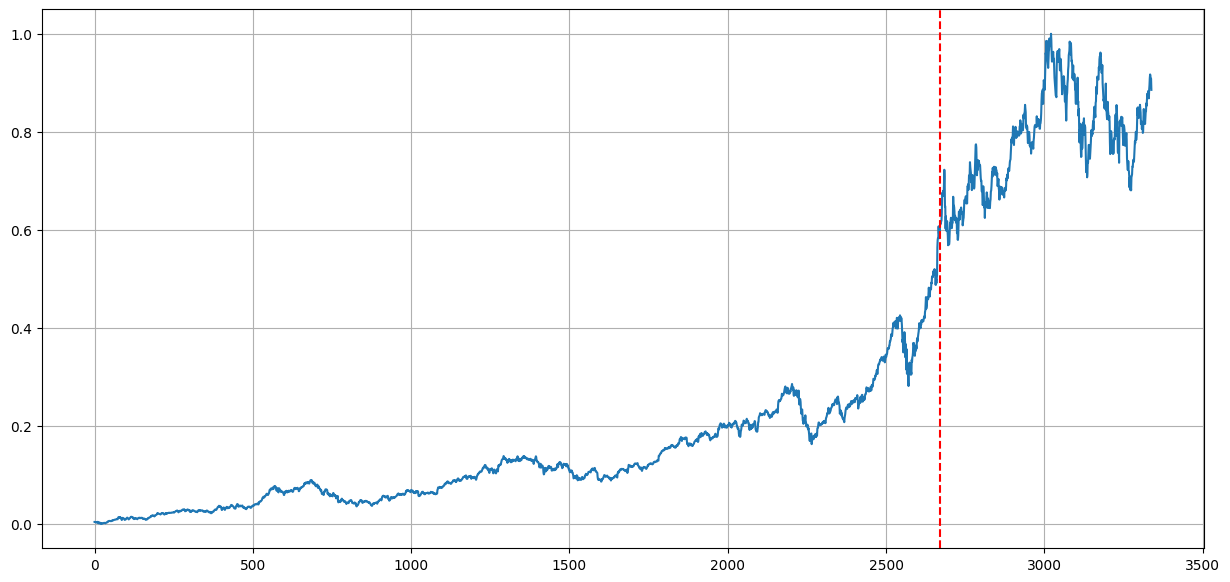

In [22]:
plt.figure(figsize=(15,7))
plt.plot(data.adj_close.tolist())
plt.axvline(len(train_data),color='red',linestyle='--')
plt.grid()
plt.show()

In [23]:
# data_loader.get_data()[0].head()

In [24]:
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset

# 시계열 데이터셋 클래스 정의
class TimeSeriesDataset(Dataset):
    def __init__(self, data, group, sequence_size, window_size, future_size, infer_mode):
        assert len([x for x in data['group'] if x not in ['train','test']])==0, \
            "data['group'] must be in ['train','test']"
        assert group in ['train','test'], \
            "group must be in ['train','test']"
        
        self.infer_mode = infer_mode
        self.group = group
        
        # make sequence
        self.train_x_list, self.train_y_list = [],[]
        self.test_x_list , self.test_y_list  = [],[]
        i=0
        while True:
            if len(data)<i+sequence_size+future_size:
                break
            grp   = data.iloc[i+sequence_size:,:]['group'].values[0]
            seq_x = data.drop(['date','group'],axis=1).iloc[i:i+sequence_size,:].values
            seq_y = data.drop(['date','group'],axis=1).iloc[i+sequence_size:i+sequence_size+future_size,-1].values
            if grp=='train':
                self.train_x_list.append(torch.Tensor(seq_x))
                self.train_y_list.append(torch.Tensor(seq_y))
            elif grp=='test':
                self.test_x_list.append(torch.Tensor(seq_x))
                self.test_y_list.append(torch.Tensor(seq_y))
            else:
                raise ValueError("data['group'] must be in ['train','test']")
            i+=window_size
            
        # make train/test set
        self.x_list, self.y_list = None, None
        if self.group=='train':
            self.x_list = self.train_x_list.copy()
            self.y_list = self.train_y_list.copy()
        elif self.group=='test':
            self.x_list = self.test_x_list.copy()
            self.y_list = self.test_y_list.copy()
        else:
            raise ValueErorr("group must be in ['train','test']")
            
    def __getitem__(self, index):
            
        data  = self.x_list[index]
        label = self.y_list[index]
        if self.infer_mode == False:
            return data, label
        else:
            return data

    def __len__(self):
        return len(self.x_list)

In [25]:
# 데이터셋 생성
train_dataset = TimeSeriesDataset(data, 'train', SEQUENCE_SIZE, WINDOW_SIZE, FUTURE_SIZE, False)
test_dataset  = TimeSeriesDataset(data, 'test' , SEQUENCE_SIZE, WINDOW_SIZE, FUTURE_SIZE, False)

# 데이터 로더 생성
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=SHUFFLE)
test_dataloader  = DataLoader(test_dataset , batch_size=BATCH_SIZE, shuffle=SHUFFLE)

In [26]:
# # 데이터셋 생성
# train_dataset = TimeSeriesDataset(train_data, SEQUENCE_SIZE, WINDOW_SIZE, FUTURE_SIZE, False)
# test_dataset  = TimeSeriesDataset(test_data , SEQUENCE_SIZE, WINDOW_SIZE, FUTURE_SIZE, False)

# # 데이터 로더 생성
# train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=SHUFFLE)
# test_dataloader  = DataLoader(test_dataset , batch_size=BATCH_SIZE, shuffle=SHUFFLE)

In [27]:
[x for x,y in train_dataloader][0].size(), [y for x,y in train_dataloader][0].size()
# [x for x,y in test_dataloader][0].size(), [y for x,y in test_dataloader][0].size()

(torch.Size([32, 21, 8]), torch.Size([32, 1]))

In [28]:
print([x for x,y in train_dataloader][0][0], [y for x,y in train_dataloader][0][0])
display(train_data.head(SEQUENCE_SIZE+1).tail())

tensor([[1.4447e-03, 1.7472e-03, 2.9537e-03, 3.4005e-03, 2.9642e-03, 3.4057e-03,
         3.2475e-03, 3.8178e-03],
        [1.7472e-03, 2.9537e-03, 3.4005e-03, 2.9642e-03, 3.4057e-03, 3.2475e-03,
         3.8178e-03, 3.8821e-03],
        [2.9537e-03, 3.4005e-03, 2.9642e-03, 3.4057e-03, 3.2475e-03, 3.8178e-03,
         3.8821e-03, 3.2893e-03],
        [3.4005e-03, 2.9642e-03, 3.4057e-03, 3.2475e-03, 3.8178e-03, 3.8821e-03,
         3.2893e-03, 3.2214e-03],
        [2.9642e-03, 3.4057e-03, 3.2475e-03, 3.8178e-03, 3.8821e-03, 3.2893e-03,
         3.2214e-03, 3.4648e-03],
        [3.4057e-03, 3.2475e-03, 3.8178e-03, 3.8821e-03, 3.2893e-03, 3.2214e-03,
         3.4648e-03, 3.1397e-03],
        [3.2475e-03, 3.8178e-03, 3.8821e-03, 3.2893e-03, 3.2214e-03, 3.4648e-03,
         3.1397e-03, 2.7242e-03],
        [3.8178e-03, 3.8821e-03, 3.2893e-03, 3.2214e-03, 3.4648e-03, 3.1397e-03,
         2.7242e-03, 3.2336e-03],
        [3.8821e-03, 3.2893e-03, 3.2214e-03, 3.4648e-03, 3.1397e-03, 2.7242e-03,

,date,adj_close_lag_7,adj_close_lag_6,adj_close_lag_5,adj_close_lag_4,adj_close_lag_3,adj_close_lag_2,adj_close_lag_1,adj_close
17,2010-01-28,6.536590,6.435975,6.324721,6.011024,6.172736,6.259975,6.318945,6.057835
18,2010-01-29,6.435975,6.324721,6.011024,6.172736,6.259975,6.318945,6.057835,5.838065
19,2010-02-01,6.324721,6.011024,6.172736,6.259975,6.318945,6.057835,5.838065,5.919224
20,2010-02-02,6.011024,6.172736,6.259975,6.318945,6.057835,5.838065,5.919224,5.953573
21,2010-02-03,6.172736,6.259975,6.318945,6.057835,5.838065,5.919224,5.953573,6.056012


In [29]:
class BiLSTM(nn.Module):
    def __init__(self, bidirectional, batch_norm, input_size, hidden_size, num_layers, output_size, dropout, seq_len):
        super(BiLSTM, self).__init__()
        self.bidirectional = bidirectional
        self.batch_norm = batch_norm
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_directions = 2 if self.bidirectional else 1
        
        self.layers = nn.ModuleList()
        self.layers.append(nn.LSTM(input_size, hidden_size, batch_first=True, bidirectional=self.bidirectional))
        for i in range(num_layers-1):
            self.layers.append(
                nn.LSTM(hidden_size*self.num_directions, hidden_size, batch_first=True, bidirectional=self.bidirectional)
            )
        
        self.fc = nn.Linear(hidden_size*self.num_directions, output_size)
        self.dropout = nn.Dropout(dropout)
        if self.batch_norm:
            self.bn1 = nn.BatchNorm1d(seq_len)     #LSTM Layer 뒤에 있을 때
            self.bn2 = nn.BatchNorm1d(output_size) #Fully Connected 뒤에 있을 때
        self.activation = nn.LeakyReLU(negative_slope=0.01) #nn.ELU()
        
        # 초기 가중치 설정
        self.init_weights()
        
    def init_weights(self):
        for layer in self.layers:
            for name, param in layer.named_parameters():
                if 'weight' in name:
                    init.xavier_normal_(param.data)
                elif 'bias' in name:
                    init.constant_(param.data, 0)
                
        init.xavier_normal_(self.fc.weight)
        init.constant_(self.fc.bias, 0)

    def forward(self, x):
        # 초기 hidden state와 cell state를 0으로 초기화
        h0 = torch.zeros(self.num_directions, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_directions, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate LSTM
        out = x
        for i in range(self.num_layers):
            out, (hn, cn) = self.layers[i](out, (h0, c0))
            out = self.dropout(out)
            # if self.batch_norm:
            #     out = self.bn1(out)
            #out = self.activation(out)
        
        # Fully connected layer
        out = out[:, -1, :] # 마지막 타임스텝의 hidden state를 선택
        out = self.fc(out)
        if self.batch_norm:
            out = self.bn2(out)
        out = self.activation(out)
        
        return out

In [30]:
data.tail()

,date,group,adj_close_lag_7,adj_close_lag_6,adj_close_lag_5,adj_close_lag_4,adj_close_lag_3,adj_close_lag_2,adj_close_lag_1,adj_close
3334,2023-04-03,test,0.875583,0.883132,0.871865,0.868262,0.886106,0.895200,0.909727,0.916991
3335,2023-04-04,test,0.883132,0.871865,0.868262,0.886106,0.895200,0.909727,0.916991,0.913902
3336,2023-04-05,test,0.871865,0.868262,0.886106,0.895200,0.909727,0.916991,0.913902,0.903207
3337,2023-04-06,test,0.868262,0.886106,0.895200,0.909727,0.916991,0.913902,0.903207,0.908354
3338,2023-04-10,test,0.886106,0.895200,0.909727,0.916991,0.913902,0.903207,0.908354,0.885526


In [31]:
# 모델 인스턴스 생성 및 손실함수, 최적화 함수 정의
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BiLSTM(
    bidirectional=BIDIRECTIONAL,
    batch_norm=BATCH_NORM,
    input_size=data.shape[1]-len(idx_features), #train_data.shape[1]-1
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    output_size=FUTURE_SIZE,
    dropout=DROPOUT,
    seq_len=SEQUENCE_SIZE,
)
model = model.to(device)
print(model)

BiLSTM(
  (layers): ModuleList(
    (0): LSTM(8, 64, batch_first=True)
    (1): LSTM(64, 64, batch_first=True)
  )
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (activation): LeakyReLU(negative_slope=0.01)
)


In [33]:
%%time

seed_everything(SEED)

criterion = nn.L1Loss()  #nn.MSELoss(),nn.HuberLoss()
optimizer = torch.optim.Adam(params=model.parameters(),lr=LEARNING_RATE,weight_decay=5e-4) # weight_decay: L2 regularization의 일종
# optimizer = torch.optim.SGD(params=model.parameters(),lr=lr,momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=10, threshold_mode='abs',min_lr=1e-7, verbose=False)
early_stopping = EarlyStopping(patience=30, verbose=False, path=None) #'./mc/checkpoint.pt'

best_model = train(
    model,
    train_dataloader,
    test_dataloader,
    criterion,
    optimizer,
    scheduler,
    device,
    num_epochs=4048,
    metric_period=1,
    target_logscale=TARGET_LOGSCALE,
    early_stopping=None,#early_stopping,
    plot=True,
    s=20,
)


KeyboardInterrupt



In [34]:
# 모델 인스턴스 생성 및 손실함수, 최적화 함수 정의
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BiLSTM(
    bidirectional=BIDIRECTIONAL,
    batch_norm=BATCH_NORM,
    input_size=data.shape[1]-len(idx_features), #train_data.shape[1]-1
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    output_size=FUTURE_SIZE,
    dropout=DROPOUT,
    seq_len=SEQUENCE_SIZE,
)
model = model.to(device)
model.load_state_dict(torch.load('./mc/best_model.pt'))
# model.load_state_dict(torch.load('./mc/final_model.pt'))

<All keys matched successfully>

In [35]:
def predict(model, dataloader, device, target_logscale):
    with torch.no_grad():
        preds = []
        trues = []
        model.eval()
        for x, y in dataloader:
            x = x.to(device)
            y = y.to(device)

            output = model(x)
            preds += output.detach().cpu().numpy().flatten().tolist()
            trues += y.detach().cpu().numpy().flatten().tolist()
            
    if target_logscale:
        preds = [np.exp(pred) for pred in preds]
        trues = [np.exp(true) for true in trues]
            
    return trues, preds

In [36]:
train_data.head()

,date,adj_close_lag_7,adj_close_lag_6,adj_close_lag_5,adj_close_lag_4,adj_close_lag_3,adj_close_lag_2,adj_close_lag_1,adj_close
0,2010-01-04,6.090360,6.143250,6.354206,6.432326,6.356031,6.433238,6.405577,6.505280
1,2010-01-05,6.143250,6.354206,6.432326,6.356031,6.433238,6.405577,6.505280,6.516528
2,2010-01-06,6.354206,6.432326,6.356031,6.433238,6.405577,6.505280,6.516528,6.412873
3,2010-01-07,6.432326,6.356031,6.433238,6.405577,6.505280,6.516528,6.412873,6.401017
4,2010-01-08,6.356031,6.433238,6.405577,6.505280,6.516528,6.412873,6.401017,6.443573


In [37]:
def inverse_transform(y,y_min,y_max):
    new_y = np.array(y)*(y_max-y_min)+y_min
    return new_y.tolist()

Train RMSE: 1.9336337772006476
Test  RMSE: 5.511247669943624
(1) Train


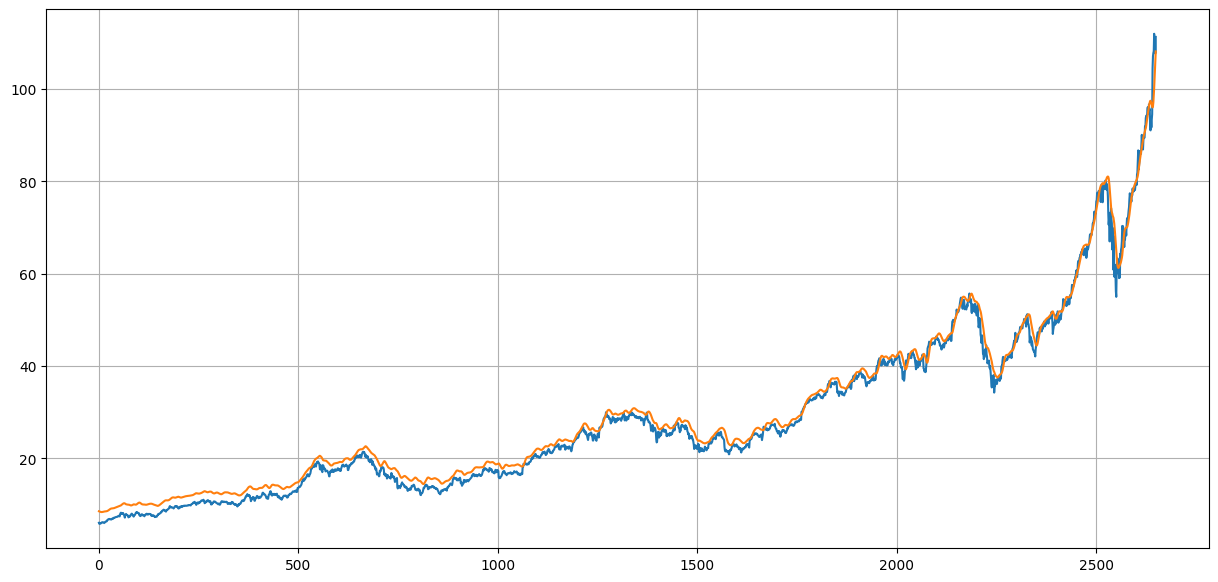

(2) Test


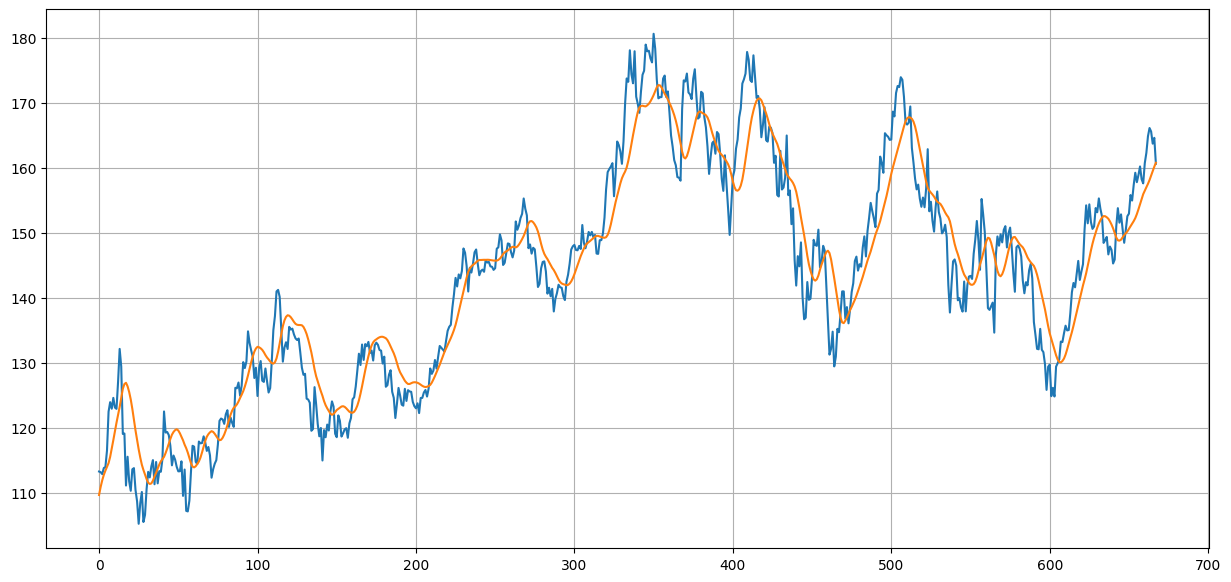

(3) Total


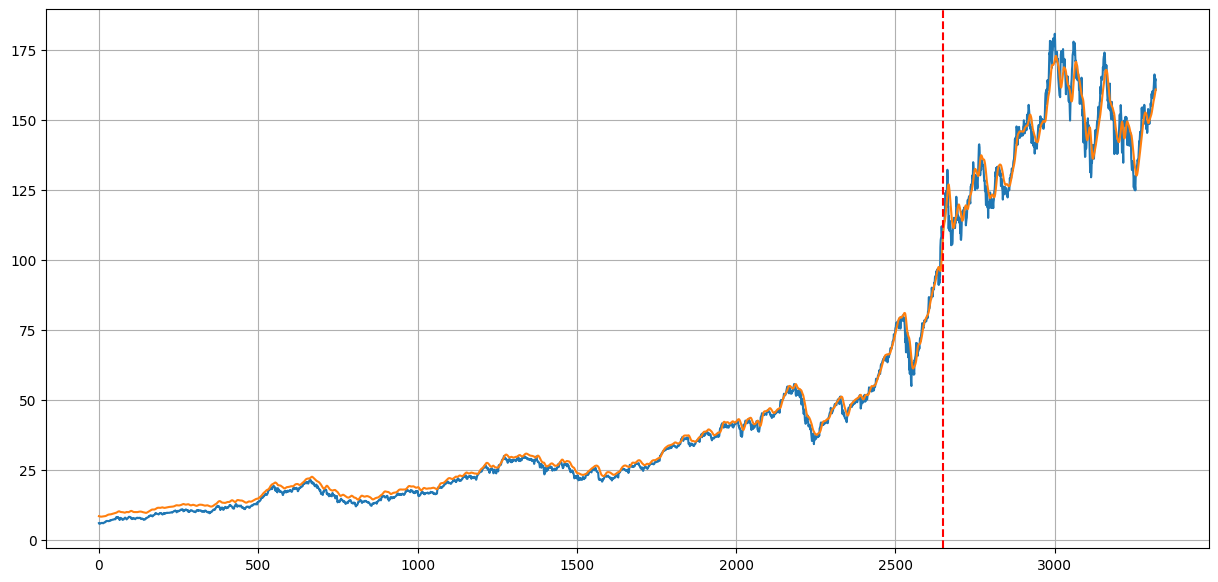

In [38]:
tr_trues, tr_preds = predict(model, train_dataloader, 'cpu', TARGET_LOGSCALE)
te_trues, te_preds = predict(model, test_dataloader , 'cpu', TARGET_LOGSCALE)

tr_trues = inverse_transform(tr_trues,y_min,y_max)
tr_preds = inverse_transform(tr_preds,y_min,y_max)
te_trues = inverse_transform(te_trues,y_min,y_max)
te_preds = inverse_transform(te_preds,y_min,y_max)

print(f'Train RMSE: {np.sqrt(mean_squared_error(tr_trues,tr_preds))}')
print(f'Test  RMSE: {np.sqrt(mean_squared_error(te_trues,te_preds))}')

print('(1) Train')
plt.figure(figsize=(15,7))
plt.plot(tr_trues)
plt.plot(tr_preds)
plt.grid()
plt.show()

print('(2) Test')
plt.figure(figsize=(15,7))
plt.plot(te_trues)
plt.plot(te_preds)
plt.grid()
plt.show()

print('(3) Total')
plt.figure(figsize=(15,7))
plt.plot(tr_trues+te_trues)
plt.plot(tr_preds+te_preds)
plt.axvline(len(tr_trues),color='red',linestyle='--')
plt.grid()
plt.show()

In [39]:
len(tr_trues), len(train_data)

(2650, 2671)

In [40]:
train_data.head()

,date,adj_close_lag_7,adj_close_lag_6,adj_close_lag_5,adj_close_lag_4,adj_close_lag_3,adj_close_lag_2,adj_close_lag_1,adj_close
0,2010-01-04,6.090360,6.143250,6.354206,6.432326,6.356031,6.433238,6.405577,6.505280
1,2010-01-05,6.143250,6.354206,6.432326,6.356031,6.433238,6.405577,6.505280,6.516528
2,2010-01-06,6.354206,6.432326,6.356031,6.433238,6.405577,6.505280,6.516528,6.412873
3,2010-01-07,6.432326,6.356031,6.433238,6.405577,6.505280,6.516528,6.412873,6.401017
4,2010-01-08,6.356031,6.433238,6.405577,6.505280,6.516528,6.412873,6.401017,6.443573


In [41]:
def predict_future(model, test_dataloader, n_future, sequence_size, target_logscale):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    last_21_days = [x for x,y in test_dataloader][-1][-1,:,:].unsqueeze(0)
    
    preds = []
    for i in range(n_future):
        with torch.no_grad():
            pred = model(last_21_days)
            preds.append(pred.item())
            
            new_data = torch.cat((last_21_days[:,-1,1:],pred),axis=1).unsqueeze(0)
            last_21_days = torch.cat((
                last_21_days[:,1:,:],
                new_data,
            ), axis=1)
            #    -3, -2, -1, -0
            # -> -2, -1, -0, pred
    
    if target_logscale:
        preds = np.exp(preds).tolist()
    
    return preds

In [42]:
n_future = 365
future_k = predict_future(model, test_dataloader, n_future, SEQUENCE_SIZE, TARGET_LOGSCALE)
future_k = inverse_transform(future_k,y_min,y_max)

(3) Total


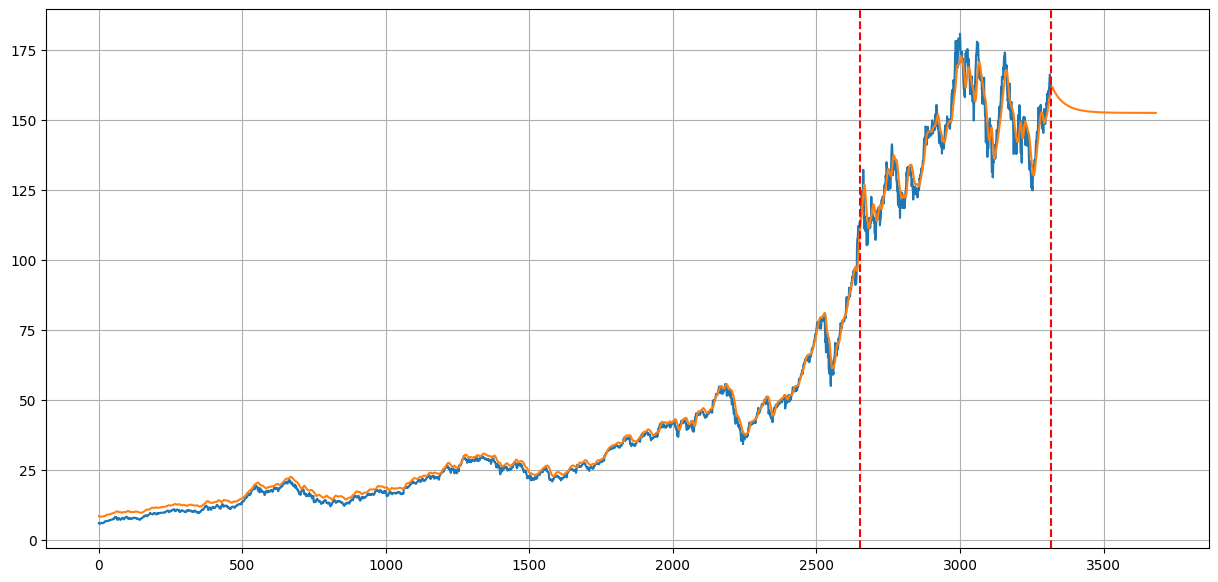

In [43]:
print('(3) Total')
plt.figure(figsize=(15,7))
plt.plot(tr_trues+te_trues+[np.nan]*n_future)
plt.plot(tr_preds+te_preds+future_k)
plt.axvline(len(tr_trues),color='red',linestyle='--')
plt.axvline(len(tr_trues+te_trues),color='red',linestyle='--')
plt.grid()
plt.show()

In [ ]:
# !pip install prophet

In [ ]:
# conda install - c conda-forge fbprophet
import pandas as pd
from prophet import Prophet

# Load data
train_data, test_data = data_loader.get_data()
train_data = train_data[['date','adj_close']].rename(columns={'date':'ds','adj_close':'y'})
test_data  = test_data [['date','adj_close']].rename(columns={'date':'ds','adj_close':'y'})

# Initialize and fit model
m = Prophet(
    changepoint_prior_scale=0.2,
    n_changepoints=200,
    seasonality_mode=['multiplicative','additive'][0],
    weekly_seasonality=True,
    daily_seasonality=True,
    yearly_seasonality=True,
)
m.fit(train_data)

# Make future predictions
future = m.make_future_dataframe(periods=len(test_data))
forecast = m.predict(future)

# Plot forecast
fig = m.plot(forecast)

In [ ]:
test_data.head()

In [ ]:
tr_pred = forecast[:len(train_data)]['yhat'].values.tolist()
te_pred = forecast[len(train_data):]['yhat'].values.tolist()

tr_true = train_data['y'].values.tolist()
te_true = test_data ['y'].values.tolist()

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(tr_true+te_true,alpha=0.7)
plt.plot(tr_pred+te_pred,alpha=0.7)
plt.grid()
plt.axvline(len(tr_true),color='red',linestyle='--')
plt.show()

In [ ]:
# def predict_future(model, dataloader, device, target_logscale, n_predict):
#     with torch.no_grad():
#         preds = []
#         trues = []
#         model.eval()
#         for x, y in dataloader:
#             x = x.to(device)
#             y = y.to(device)

#             output = model(x)
#             preds += output.detach().cpu().numpy().flatten().tolist()
#             trues += y.detach().cpu().numpy().flatten().tolist()

#         # 예측한 주가를 n_predict만큼 미래로 확장
#         last_price = trues[-1]
#         for i in range(n_predict):
#             x_pred = torch.Tensor([last_price]).view(1, 1, 1).to(device)
#             print(x_pred)
#             output = model(x_pred)
#             pred = output.detach().cpu().numpy().flatten().tolist()[0]
#             if target_logscale:
#                 pred = np.exp(pred)
#             preds.append(pred)
#             last_price = pred

#         # 실제 주가와 예측한 주가 반환
#         if target_logscale:
#             trues = [np.exp(true) for true in trues]
#         return trues, preds

In [ ]:
predict_future(model, train_dataloader, 'cpu', TARGET_LOGSCALE, 30)

In [ ]:
def predict_future(model, data, n_predict):
    model.eval()
    with torch.no_grad():
        last_data = data[-4:].values.astype('float32')
        predicted_prices = []
        for i in range(n_predict):
            inputs = torch.tensor(last_data).unsqueeze(0)
            output = model(inputs)
            predicted_price = output.item()
            predicted_prices.append(predicted_price)
            last_data = np.concatenate([last_data[1:], [predicted_price]])            
    return predicted_prices

In [ ]:
train_data.shape

In [ ]:
for i in range(1,31):
    print(train_data.iloc[-31-30+i:-31+i,:].shape)

In [ ]:
x = train_data.iloc[-31-30+i:-31+i,:-1]
x = torch.Tensor(x.values)
x.shape

In [ ]:
x = train_data.iloc[-31-30+i:-31+i,:-1].values


In [ ]:
with torch.no_grad():
    
    predictions = []
    actuals = [] 
    model.eval()

    for i in range(1, 31):
        x = train_data.iloc[-31-30+i:-31+i,:-1].values
        y = train_data.iloc[-31-30+i:-31+i,-1].values[-1]
        
        x = x.reshape(x.shape[0],1,x.shape[1])
        x = torch.Tensor(x)
        output = model(x)
        predictions.append(output[-1].numpy()[0])
        actuals.append(y)

In [ ]:
plot_df = pd.DataFrame({
    'true':actuals,
    'pred':predictions,
})

# 예측 결과 시각화
plt.figure(figsize=(10, 6))
plt.plot(plot_df.true, label='Actual')
plt.plot(plot_df.pred, label='Predicted')
plt.legend()
plt.show()

<br></br>

In [ ]:
# seed_everything(SEED)

adj_close = pd.concat([train_data,test_data],axis=0)[['adj_close']]

# Create sequences
seq_len = 21
data = []
for i in range(len(adj_close)-seq_len):
    data.append(adj_close[i:i+seq_len])
data = np.array(data)

# Split data into train and test sets
train_size = 0.8
n_train = int(len(data)*train_size)
train_set, test_set = data[:n_train], data[n_train:]

# Define LSTM model
class LSTM(nn.Module):
    def __init__(self, seq_len, input_size=1, hidden_size=64, num_layers=2, output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.activation = nn.ReLU()
        self.bn = nn.BatchNorm1d(seq_len)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        out = self.fc(out)
        out = self.activation(out)
        return out
    
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate LSTM model and move to device
model = LSTM(seq_len=seq_len# Train model and save the best model
best_model = None
best_test_score = float('inf')
num_epochs = 100
for epoch in range(num_epochs):
    train_loss = []
    for seq in train_set:
        seq = torch.tensor(seq).float().unsqueeze(0).to(device)
        label = seq[:, -1, :].to(device)
        optimizer.zero_grad()
        output = model(seq)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        train_loss += loss
    if (epoch+1) % 1 == 0:
        #print(output,label)
        with torch.no_grad():
            test_inputs = torch.from_numpy(test_set[:, :-1]).float().to(device)
            test_labels = torch.from_numpy(test_set[:, -1]).float().to(device)
            test_predictions = []
            for i in range(len(test_inputs)):
                seq = test_inputs[i].unsqueeze(0)
                with torch.no_grad():
                    test_predictions.append(model(seq).item())
            test_score = criterion(torch.tensor(test_predictions), test_labels).item()
            if test_score < best_test_score:
                torch.save(model.state_dict(), './mc/best_model.pth')
                best_test_score = test_score
                best_model = model
                is_best = 1
            else:
                is_best = 0
                
        progress_text = '{}Epoch [{}/{}], Train Loss: {:.4f}, Test Loss: {:.4f}'\
            .format(np.where(is_best==1,'*',' '),epoch+1, num_epochs, loss, test_score)
        print(progress_text)).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)



In [ ]:
# Load the best model
best_model = LSTM(seq_len=seq_len).to(device)
best_model.load_state_dict(torch.load('./mc/best_model.pth'))

# Make train predictions
train_inputs = torch.from_numpy(train_set[:, :-1]).float().to(device)
train_labels = torch.from_numpy(train_set[:, -1]).float().to(device)
train_predictions = []
for i in range(len(train_inputs)):
    seq = train_inputs[i].unsqueeze(0)
    with torch.no_grad():
        train_predictions.append(best_model(seq).item())

In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(train_labels.cpu().numpy(), train_predictions)

In [ ]:
# Load the best model
best_model = LSTM(seq_len=seq_len).to(device)
best_model.load_state_dict(torch.load('./mc/best_model.pth'))

# Make train predictions
test_inputs = torch.from_numpy(test_set[:, :-1]).float().to(device)
test_labels = torch.from_numpy(test_set[:, -1]).float().to(device)
test_predictions = []
for i in range(len(test_inputs)):
    seq = test_inputs[i].unsqueeze(0)
    with torch.no_grad():
        test_predictions.append(best_model(seq).item())

In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(test_labels.cpu().numpy(), test_predictions)

In [ ]:
true = adj_close['adj_close'].values.tolist()
true = true[7:]
pred = train_predictions + test_predictions

len(true),len(pred)

import matplotlib.pyplot as plt
plt.plot(true, label='Actual')
plt.plot(pred, label='Predicted')
plt.legend()
plt.axvline(len(train_predictions),color='red',linestyle='--')
plt.show()